# Problem Statement

Stock market is always unpredictable. Banks and traders are always looking out to improve their trading strategies. Any information or indicators that able to give an edge or advantage is always sought after. The President of United States, Donald Trump currently has 87.2 millions followers on Twitter under the handle of @realDonaldTrump. Lucky for traders, the President is highly active on his twitter account and isn't shy about tweeting his views basically on anything. By understanding the impact(positive/negative) of President Trump’s tweets has in the Stock market, this will improve one’s investing/trading strategies.

I will analyze President Trump's tweets begining from his presidency in 2017. Using natural language processing(NLP) tools such as topic modeling to assign each tweet a topic, after identifying the topic, each tweet is then assigned a sentiment score which will be used in the modelling. I will build a classification model that will look into the text features of President Trump tweets and how it can be classified to have positive or negative impact on the market. As this model can be use as an indicator for buy and sell signals, we want to want have high accuracy on both true positive and negative therefore our success will be measured by the AUC/ROC score. 

# Data Cleaning

In [1]:
import pandas as pd
import numpy as np
import re
from datetime import datetime, timezone
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

In [2]:
#load the data from json
tweets = pd.read_json("../datasets/trump_tweets.json")

In [3]:
tweets.head(10)

,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str
0,Twitter for iPhone,Mike Pence WON BIG!,2020-10-08 02:57:08+00:00,65210,418654,0.0,1314037081392525312
1,Twitter for iPhone,https://t.co/yPrw5jqgGV,2020-10-08 02:56:46+00:00,20225,88262,0.0,1314036989226778624
2,Twitter for iPhone,https://t.co/wHQx2qd8q2,2020-10-08 02:49:05+00:00,23424,79991,0.0,1314035056441257984
3,Twitter for iPhone,"2010 to 2016 under Kamala Harris's watch as ""T...",2020-10-08 02:40:57+00:00,26438,70249,0.0,1314033009293656064
4,Twitter for iPhone,https://t.co/4Wv5cCFEns https://t.co/kMvBv6Pu9I,2020-10-08 02:24:56+00:00,11798,40743,0.0,1314028978806624256
5,Twitter for iPhone,https://t.co/rxqPqR4uqZ,2020-10-08 02:23:49+00:00,22052,93256,0.0,1314028699084259328
6,Twitter for iPhone,https://t.co/xGevgI2wTO,2020-10-08 02:20:57+00:00,16190,54819,0.0,1314027975185182720
7,Twitter for iPhone,RT @Mike_Pence: https://t.co/30WSe3sXxv,2020-10-08 02:20:18+00:00,16920,0,1.0,1314027813318594560
8,Twitter for iPhone,RT @Mike_Pence: https://t.co/5suIpyyxVD,2020-10-08 02:11:50+00:00,9380,0,1.0,1314025683174203392
9,Twitter for iPhone,Moderator cut off @VP Mike Pence while discuss...,2020-10-08 02:09:36+00:00,28864,73680,0.0,1314025119497551872


In [4]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23357 entries, 0 to 23356
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   source          23357 non-null  object             
 1   text            23357 non-null  object             
 2   created_at      23357 non-null  datetime64[ns, UTC]
 3   retweet_count   23357 non-null  int64              
 4   favorite_count  23357 non-null  int64              
 5   is_retweet      23299 non-null  float64            
 6   id_str          23357 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(1), int64(3), object(2)
memory usage: 1.2+ MB


In [5]:
tweets["is_retweet"].isnull().sum()

58

In [6]:
tweets[tweets["is_retweet"].isnull()]

,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str
20836,Twitter for iPhone,Thanks to all of the Republican and Democratic...,2018-01-09 22:51:50+00:00,11718,58068,NaN,950862709599465472
20837,Twitter for iPhone,"It was my great honor to sign H.R. 267, the “M...",2018-01-09 20:17:17+00:00,17249,73554,NaN,950823813868122112
20838,Twitter for iPhone,"On behalf of the American people, THANK YOU to...",2018-01-09 17:11:23+00:00,26793,112613,NaN,950777029816963072
20839,Twitter for iPhone,"We are fighting for our farmers, for our count...",2018-01-08 23:19:47+00:00,22044,104968,NaN,950507353094356992
20840,Twitter for iPhone,"In every decision we make, we are honoring Ame...",2018-01-08 22:59:37+00:00,17769,81027,NaN,950502279785959424
20841,Twitter for iPhone,We have been working every day to DELIVER for ...,2018-01-08 22:58:13+00:00,11561,57809,NaN,950501926227136512
20842,Twitter for iPhone,Can’t wait to be back in the amazing state of ...,2018-01-08 19:06:40+00:00,10242,54355,NaN,950443653666713600
20843,Twitter for iPhone,African American unemployment is the lowest ev...,2018-01-08 14:20:25+00:00,34648,132122,NaN,950371619247153152
20844,Twitter for iPhone,"...Clinton in the WH, doubling down on Barack ...",2018-01-08 03:24:23+00:00,18904,83265,NaN,950206523690639360
20845,Twitter for iPhone,“His is turning out to be an enormously conseq...,2018-01-08 03:23:39+00:00,16880,82631,NaN,950206338411499520


After investigating the null values in "is_retweet", we have conclude that they are not retweets and hence will assign 0 to it.

In [7]:
tweets["is_retweet"].fillna(0, inplace=True)

In [8]:
tweets["is_retweet"].isnull().sum()

0

In [9]:
#drop the columns that does not provide useful information
tweets.drop(columns=["source", "id_str"], inplace=True)

Donald trump seems to tweet alot of pictures/videos which are url links that at this point we are unable to interpret, hence we decided to remove url links from the text as it does not provide any information. In this inital cleaning we also remove punctuations and the twitter handler sign @

In [10]:
#create function to clean the text
def clean_text(text):
    return " ".join(re.sub(r"(\w+://.+)|(@[a-zA-Z0-9]+)|([^A-Za-z0-9])" , " ", text).split())

        

In [11]:
tweets['clean_text'] = tweets['text'].apply(lambda text: clean_text(text))

In [12]:
#remove rows that have spaces only
for i in range(len(tweets['clean_text'])):
    if len(tweets['clean_text'][i]) < 1:
        tweets.drop(index=i, inplace=True)
        

In [13]:
#reset the index
tweets.reset_index(drop=True, inplace=True)

In [14]:
tweets.shape

(22395, 6)

The data collected was on UTC time, as we are trying to predict if trump tweet has any impact on the stock market, we have to convert to the same timezone which is US/Eastern.

In [15]:
#create a function to convert timezone
def convert_time(time):
    return time.astimezone(tz="US/Eastern")

In [16]:
tweets["created_at"]  = tweets["created_at"].apply(lambda x: convert_time(x))

In [17]:
tweets["year"] = tweets["created_at"].dt.year

In [18]:
tweets["month"] = tweets["created_at"].dt.month

In [19]:
tweets["day"] = tweets["created_at"].dt.day

In [20]:
tweets["time"] = tweets["created_at"].dt.time

In [21]:
tweets["year_month"] = tweets["created_at"].dt.strftime("%Y-%m")

In [22]:
tweets["day_of_week"] = tweets["created_at"].dt.weekday

In [23]:
tweets["hour_of_day"] = tweets["created_at"].dt.strftime("%H")

In [24]:
tweets.shape

(22395, 13)

Trump also have alot of retweets, by extracting the handlers of his retweet might give us more insights. 

In [25]:
def find_handler(text):
        handler = re.search(r"(@[\w]+)", text)
        
        if handler != None:
            return re.search(r"(@[\w]+)", text).group(0)
        else:
            return None
                       

In [26]:
tweets["handler"] = tweets["text"].apply(lambda handler: find_handler(handler))

In [27]:
tweets.shape

(22395, 14)

In [28]:
tweets.head()

,text,created_at,retweet_count,favorite_count,is_retweet,clean_text,year,month,day,time,year_month,day_of_week,hour_of_day,handler
0,Mike Pence WON BIG!,2020-10-07 22:57:08-04:00,65210,418654,0.0,Mike Pence WON BIG,2020,10,7,22:57:08,2020-10,2,22,None
1,"2010 to 2016 under Kamala Harris's watch as ""T...",2020-10-07 22:40:57-04:00,26438,70249,0.0,2010 to 2016 under Kamala Harris s watch as TO...,2020,10,7,22:40:57,2020-10,2,22,None
2,RT @Mike_Pence: https://t.co/30WSe3sXxv,2020-10-07 22:20:18-04:00,16920,0,1.0,RT Pence,2020,10,7,22:20:18,2020-10,2,22,@Mike_Pence
3,RT @Mike_Pence: https://t.co/5suIpyyxVD,2020-10-07 22:11:50-04:00,9380,0,1.0,RT Pence,2020,10,7,22:11:50,2020-10,2,22,@Mike_Pence
4,Moderator cut off @VP Mike Pence while discuss...,2020-10-07 22:09:36-04:00,28864,73680,0.0,Moderator cut off Mike Pence while discussing ...,2020,10,7,22:09:36,2020-10,2,22,@VP


# EDA

## Total Number Tweets

In [29]:
len(tweets)

22395

## Tweets count by year

In [30]:
tweets[["text", "year", "is_retweet"]].groupby(["year", "is_retweet"]).count()

text
year is_retweet      
2017 0.0         2162
     1.0          301
2018 0.0         3051
     1.0          464
2019 0.0         6664
     1.0          884
2020 0.0         8533
     1.0          336

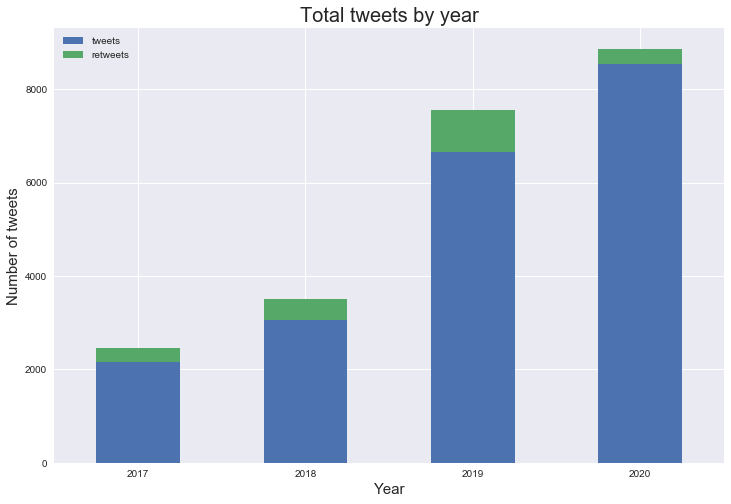

In [31]:
fig, ax = plt.subplots(figsize=(12,8))
total_tweets = tweets[["text", "year", "is_retweet"]].groupby(["year", "is_retweet"]).count().unstack()
total_tweets.plot(kind="bar", ax=ax, stacked=True)
ax.set_title("Total tweets by year", fontsize=20)
ax.set_xlabel("Year", fontsize=15)
ax.set_xticklabels(total_tweets.index, rotation=0)
ax.set_ylabel("Number of tweets", fontsize=15)
ax.legend(labels=["tweets", "retweets"])

From here we observed that Donald Trump has increase his number of tweets over the years since he became US president in 2017. This same goes for his retweets where we see an increase numbers since 2017 however there's an decrease in 2020, this might be due to the fact that the data collected for 2020 is until Oct. 

## Tweets count by month

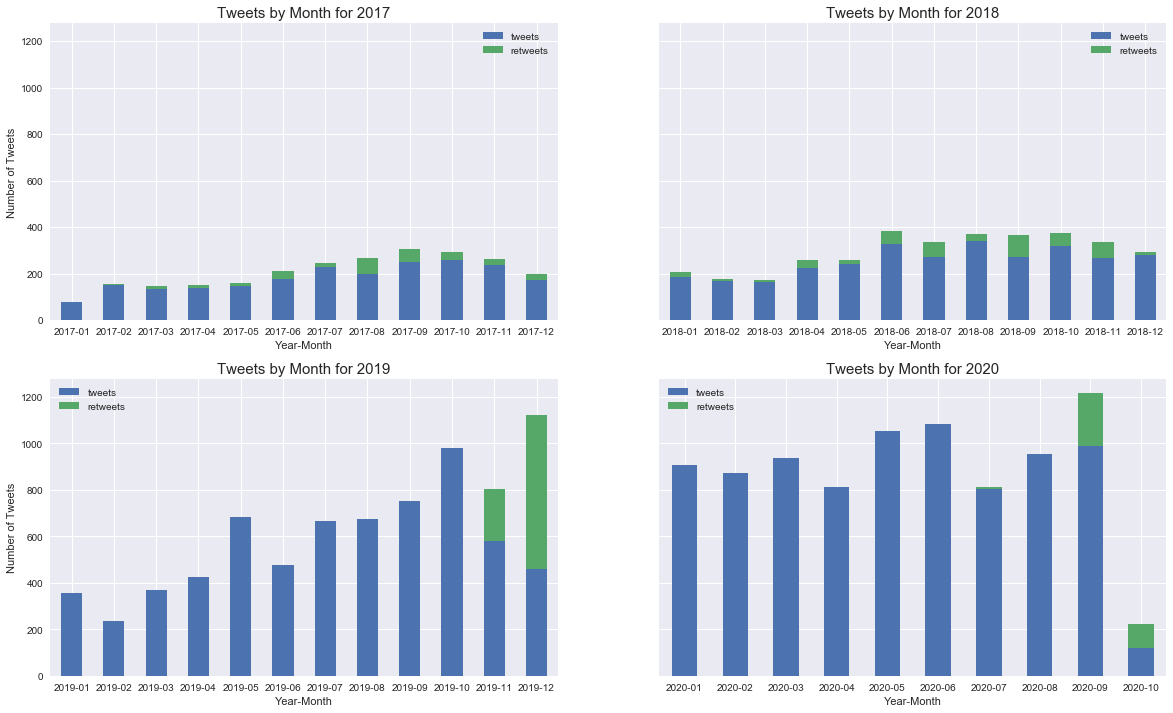

In [32]:
fig, ax = plt.subplots(figsize=(20,12), nrows=2, ncols=2, sharey="all")
ax = ax.ravel()

for i, year in enumerate(np.sort(tweets["year"].unique())):

    year_month = tweets[tweets["year"] == year]
    year_month = year_month[["year_month", "text", "is_retweet"]].groupby(["year_month", "is_retweet"]).count().unstack()
    year_month.plot(kind='bar',ax=ax[i], stacked=True)
    ax[i].set_xlabel("Year-Month")
    ax[i].set_xticklabels(year_month.index, rotation=0)
    ax[i].set_ylabel("Number of Tweets")
    ax[i].set_title(f"Tweets by Month for {year}", fontsize=15)
    ax[i].legend(labels=["tweets", "retweets"])
    


In general, Trump posted more tweets in the last quarter of each year. One interesting finding is that in 2019 December he retweeted more than his own tweets. 

## Tweet count by day of week

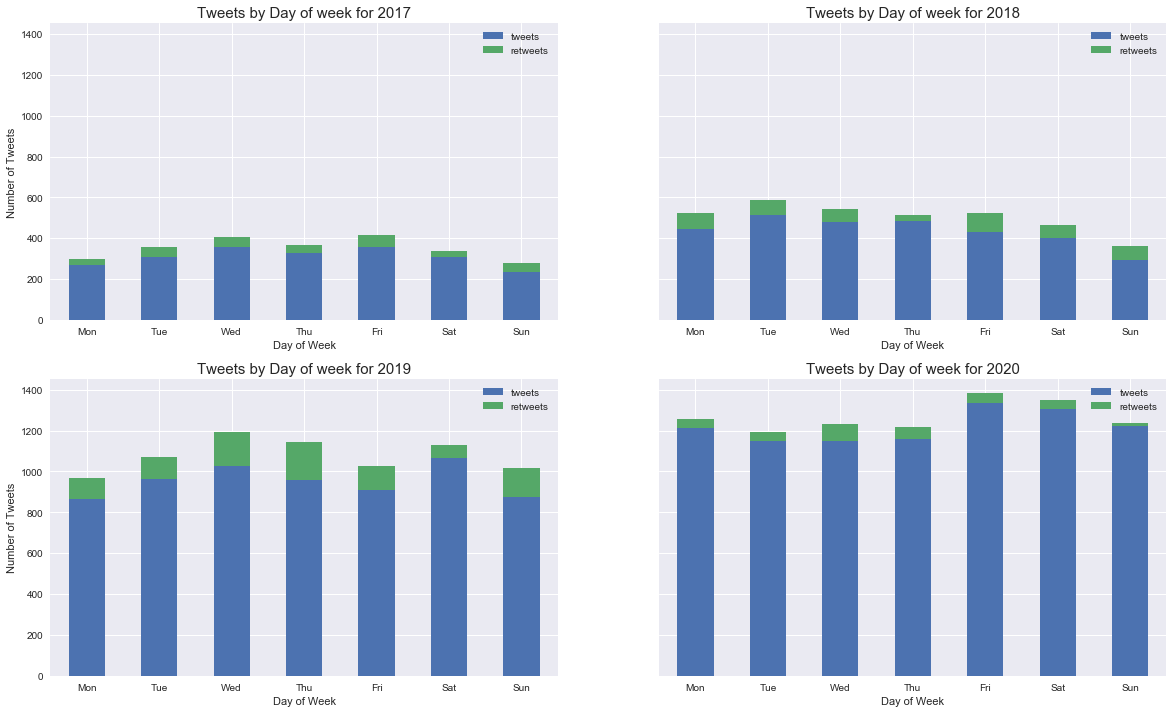

In [33]:
fig, ax = plt.subplots(figsize=(20,12), nrows=2, ncols=2, sharey="all")
ax = ax.ravel()

for i, year in enumerate(np.sort(tweets["year"].unique())):

    day_of_week = tweets[tweets["year"] == year]
    day_of_week = day_of_week[["day_of_week", "text", "is_retweet"]].groupby(["day_of_week", "is_retweet"]).count().unstack()
    day_of_week.plot(kind='bar',ax=ax[i], stacked=True)
    ax[i].set_xlabel("Day of Week")
    day_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
    ax[i].set_xticklabels(day_labels, rotation=0)
    ax[i].set_ylabel("Number of Tweets")
    ax[i].set_title(f"Tweets by Day of week for {year}", fontsize=15)
    ax[i].legend(labels=["tweets", "retweets"])
    


We observed that President Trump usually tweets more on friday than any other day of the week. 

## Tweet count by hour of day

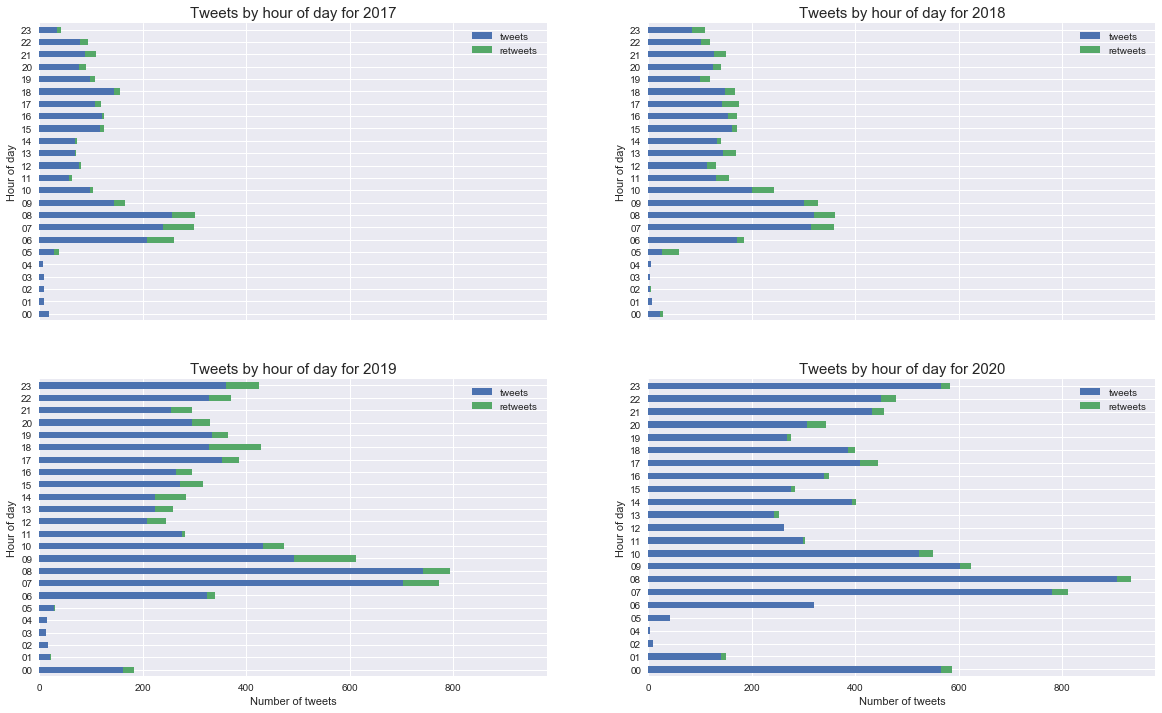

In [34]:
fig, ax = plt.subplots(figsize=(20,12), nrows=2, ncols=2, sharex="all")
ax = ax.ravel()

for i, year in enumerate(np.sort(tweets["year"].unique())):

    hour_of_day = tweets[tweets["year"] == year]
    hour_of_day = hour_of_day[["hour_of_day", "text", "is_retweet"]].groupby(["hour_of_day", "is_retweet"]).count().unstack()
    hour_of_day.plot(kind='barh',ax=ax[i], stacked=True)
    ax[i].set_xlabel("Number of tweets")
    ax[i].set_ylabel("Hour of day")
    ax[i].set_title(f"Tweets by hour of day for {year}", fontsize=15)
    ax[i].legend(labels=["tweets", "retweets"])
    

President Trump is most active betweeen 6am to 8am everyday. Most of his tweets are posted during this period in the past 4 years. 

## Top 10 most likes Tweets

Text(0.5, 1.0, 'Top 10 most likes Tweets')

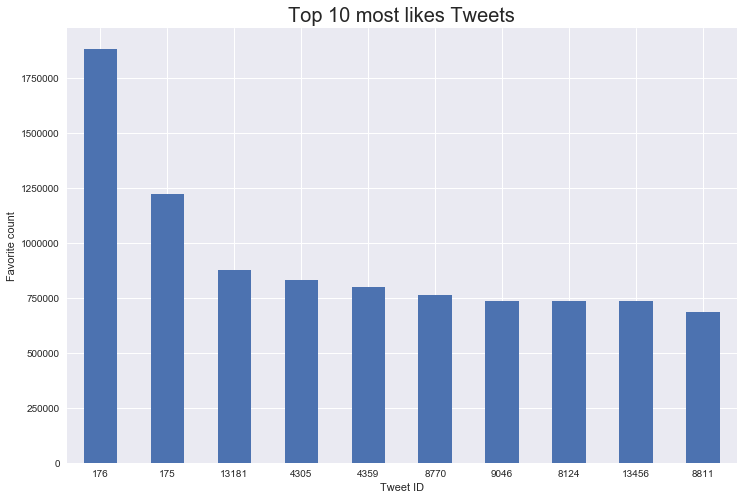

In [35]:
fig,ax = plt.subplots(figsize=(12,8))
fav_tweets = tweets["favorite_count"].sort_values(ascending=False)[:10]
fav_tweets.plot(kind='bar')
ax.set_xlabel("Tweet ID")
ax.set_xticklabels(fav_tweets.index, rotation=0)
ax.set_ylabel("Favorite count")
ax.set_title("Top 10 most likes Tweets", fontsize=20)

In [36]:
for i, index in enumerate(fav_tweets.index):
    print(f" Number {i+1}:\n {tweets.iloc[index].text}")
    print("")

 Number 1:
 Tonight, @FLOTUS and I tested positive for COVID-19. We will begin our quarantine and recovery process immediately. We will get through this TOGETHER!

 Number 2:
 Going welI, I think! Thank you to all. LOVE!!!

 Number 3:
 A$AP Rocky released from prison and on his way home to the United States from Sweden. It was a Rocky Week, get home ASAP A$AP!

 Number 4:
 The United States of America will be designating ANTIFA as a Terrorist Organization.

 Number 5:
 CHINA!

 Number 6:
 All is well! Missiles launched from Iran at two military bases located in Iraq. Assessment of casualties &amp; damages taking place now. So far, so good! We have the most powerful and well equipped military anywhere in the world, by far! I will be making a statement tomorrow morning.

 Number 7:
 MERRY CHRISTMAS!

 Number 8:
 Kobe Bryant, despite being one of the truly great basketball players of all time, was just getting started in life. He loved his family so much, and had such strong passion for t

## Top 10 most mentioned

Text(0.5, 1.0, 'Top 10 most mentioned')

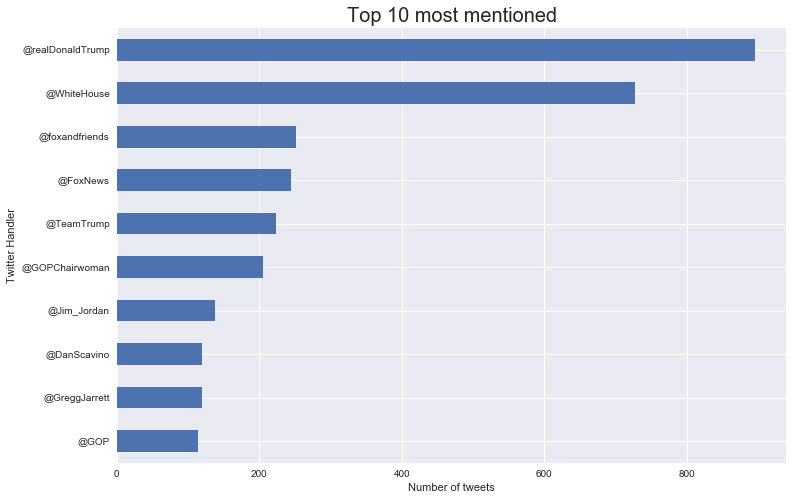

In [37]:
fig, ax = plt.subplots(figsize=(12,8))
tweets["handler"].value_counts()[:10].sort_values().plot(kind='barh')
ax.set_xlabel("Number of tweets")
ax.set_ylabel("Twitter Handler")
ax.set_title("Top 10 most mentioned", fontsize=20)

## Top 10 most retweeted

Text(0, 0.5, 'Number of Tweets')

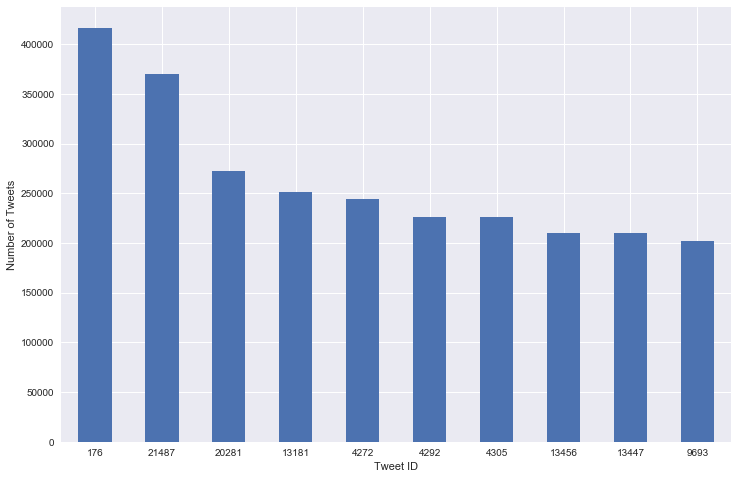

In [48]:
fig, ax = plt.subplots(figsize=(12,8))
top_retweets = tweets["retweet_count"].sort_values(ascending=False).head(10)
top_retweets.plot(kind="bar")
ax.set_xlabel("Tweet ID")
ax.set_xticklabels(top_retweets.index, rotation=0)
ax.set_ylabel("Number of Tweets")

In [54]:
for i, index in enumerate(top_retweets.index):
    print(f" Number {i+1}:\n {tweets.iloc[index].text}")
    print("")

 Number 1:
 Tonight, @FLOTUS and I tested positive for COVID-19. We will begin our quarantine and recovery process immediately. We will get through this TOGETHER!

 Number 2:
 #FraudNewsCNN #FNN https://t.co/WYUnHjjUjg

 Number 3:
 Why would Kim Jong-un insult me by calling me "old," when I would NEVER call him "short and fat?" Oh well, I try so hard to be his friend - and maybe someday that will happen!

 Number 4:
 A$AP Rocky released from prison and on his way home to the United States from Sweden. It was a Rocky Week, get home ASAP A$AP!

 Number 5:
 RT @SpaceX: Liftoff! https://t.co/DRBfdUM7JA

 Number 6:
 RT @realDonaldTrump: The United States of America will be designating ANTIFA as a Terrorist Organization.

 Number 7:
 The United States of America will be designating ANTIFA as a Terrorist Organization.

 Number 8:
 Just spoke to @KanyeWest about his friend A$AP Rocky’s incarceration. I will be calling the very talented Prime Minister of Sweden to see what we can do about helpi